In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import os
import os.path as osp
import json
import math
from glob import glob
from pprint import pprint

import torch
import matplotlib.pyplot as plt
import numpy as np
import cv2
import albumentations as A
import lanms
from albumentations.pytorch import ToTensorV2
from imageio import imread

from model import EAST
from detect import detect

### 데이터셋 불러오기

In [14]:
DATASET_DIR = './input/data/ICDAR17_Korean'  # FIXME

In [15]:
ufo_fpath = osp.join(DATASET_DIR, 'ufo/train.json')
with open(ufo_fpath, 'r') as f:
    ufo_anno = json.load(f)

In [16]:
print(ufo_anno.keys())

dict_keys(['images'])


In [17]:
print(len(ufo_anno['images']))

536


In [18]:
sample_ids = sorted(ufo_anno['images'])
print(sample_ids[:10])

['img_1001.jpg', 'img_1002.jpg', 'img_1003.jpg', 'img_1004.jpg', 'img_1011.jpg', 'img_1015.jpg', 'img_1017.jpg', 'img_1019.jpg', 'img_1023.jpg', 'img_1024.jpg']


### UFO Annotation 살펴보기

Annotation은 UFO에 맞춰 작성되어 있습니다. (UFO에 대한 자세한 설명은 5강 내용을 참조)

Annotation은 다양한 정보를 포함하고 있는데, EAST 학습을 위해 이용하는 정보는 아래와 같습니다.
- `points`: bbox의 좌표값. shape: (N, 4, 2)
- `illegibility`: 식별이 어려운 상태인지의 여부. 일반적으로 `illegibility=True`인 글자 영역은 masking을 하여 학습에서 무시하도록 합니다.

In [19]:
# 예시로 첫 번째 샘플에 대한 Annotation을 출력해본다.
first_sample_id = sample_ids[0]
pprint(ufo_anno['images'][first_sample_id])

{'img_h': 2448,
 'img_w': 1836,
 'license_tag': {'commercial': True,
                 'holder': None,
                 'public': True,
                 'type': 'CC-BY-SA',
                 'usability': True},
 'tags': None,
 'words': {'0': {'illegibility': False,
                 'language': ['ko'],
                 'orientation': 'Horizontal',
                 'points': [[80.0, 807.0],
                            [607.0, 812.0],
                            [592.0, 1037.0],
                            [126.0, 1037.0]],
                 'transcription': '얼음,',
                 'word_tags': None},
           '1': {'illegibility': False,
                 'language': ['ko'],
                 'orientation': 'Horizontal',
                 'points': [[678.0, 793.0],
                            [1160.0, 803.0],
                            [1155.0, 1037.0],
                            [691.0, 1037.0]],
                 'transcription': '석유',
                 'word_tags': None},
           '2': 

### 예시로 살펴볼 샘플 정보 불러오기

In [20]:
SAMPLE_IDX = 209

sample_id = sample_ids[SAMPLE_IDX]
image_fpath = osp.join(DATASET_DIR, 'images', sample_id)
image = imread(image_fpath)

print('Image:\t{}'.format(image.shape))

bboxes, labels = [], []
for word_info in ufo_anno['images'][sample_id]['words'].values():
    bboxes.append(np.array(word_info['points']))
    labels.append(int(not word_info['illegibility']))
bboxes, labels = np.array(bboxes, dtype=np.float32), np.array(labels, dtype=np.float32)

print('Bboxes:\t{}'.format(bboxes.shape))
print('Labels:\t{}'.format(labels.shape))

Image:	(2448, 1836, 3)
Bboxes:	(5, 4, 2)
Labels:	(5,)


### 이미지와 Annotation 시각화

In [21]:
def draw_bbox(image, bbox, color=(0, 0, 255), thickness=1, thickness_sub=None, double_lined=False,
              write_point_numbers=False):
    thickness_sub = thickness_sub or thickness * 3
    basis = max(image.shape[:2])
    fontsize = basis / 1500
    x_offset, y_offset = int(fontsize * 12), int(fontsize * 10)
    color_sub = (255 - color[0], 255 - color[1], 255 - color[2])

    points = [(int(np.rint(p[0])), int(np.rint(p[1]))) for p in bbox]

    for idx in range(len(points)):
        if double_lined:
            cv2.line(image, points[idx], points[(idx + 1) % len(points)], color_sub,
                     thickness=thickness_sub)
        cv2.line(image, points[idx], points[(idx + 1) % len(points)], color, thickness=thickness)

    if write_point_numbers:
        for idx in range(len(points)):
            loc = (points[idx][0] - x_offset, points[idx][1] - y_offset)
            if double_lined:
                cv2.putText(image, str(idx), loc, cv2.FONT_HERSHEY_SIMPLEX, fontsize, color_sub,
                            thickness_sub, cv2.LINE_AA)
            cv2.putText(image, str(idx), loc, cv2.FONT_HERSHEY_SIMPLEX, fontsize, color, thickness,
                        cv2.LINE_AA)


def draw_bboxes(image, bboxes, color=(0, 0, 255), thickness=1, thickness_sub=None,
                double_lined=False, write_point_numbers=False):
    for bbox in bboxes:
        draw_bbox(image, bbox, color=color, thickness=thickness, thickness_sub=thickness_sub,
                  double_lined=double_lined, write_point_numbers=write_point_numbers)
        

def gray_mask_to_heatmap(x):
    x = cv2.cvtColor(cv2.applyColorMap(x, cv2.COLORMAP_JET), cv2.COLOR_BGR2RGB)
    return x


def get_superimposed_image(image, score_map, heatmap=True, w_image=None, w_map=None):
    """
    Args:
        image (ndarray): (H, W, C) shaped, float32 or uint8 dtype is allowed.
        score_map (ndarray): (H, W) shaped, float32 or uint8 dtype is allowed.
        heatmap (boot): Wheather to convert `score_map` into a heatmap.
        w_image (float)
        w_map (float)

    Blending weights(`w_image` and `w_map`) are default to (0.4, 0.6).
    """

    assert w_image is None or (w_image > 0 and w_image < 1)
    assert w_map is None or (w_map > 0 and w_map < 1)

    if image.dtype != np.uint8:
        image = (255 * np.clip(image, 0, 1)).astype(np.uint8)

    if score_map.dtype != np.uint8:
        score_map = (255 * np.clip(score_map, 0, 1)).astype(np.uint8)
    if heatmap:
        score_map = gray_mask_to_heatmap(score_map)
    elif score_map.ndim == 2 or score_map.shape[2] != 3:
        score_map = cv2.cvtColor(score_map, cv2.COLOR_GRAY2RGB)

    if w_image is None and w_map is None:
        w_image, w_map = 0.4, 0.6
    elif w_image is None:
        w_image = 1 - w_map
    elif w_map is None:
        w_map = 1 - w_image

    return cv2.addWeighted(image, w_image, score_map, w_map, 0)

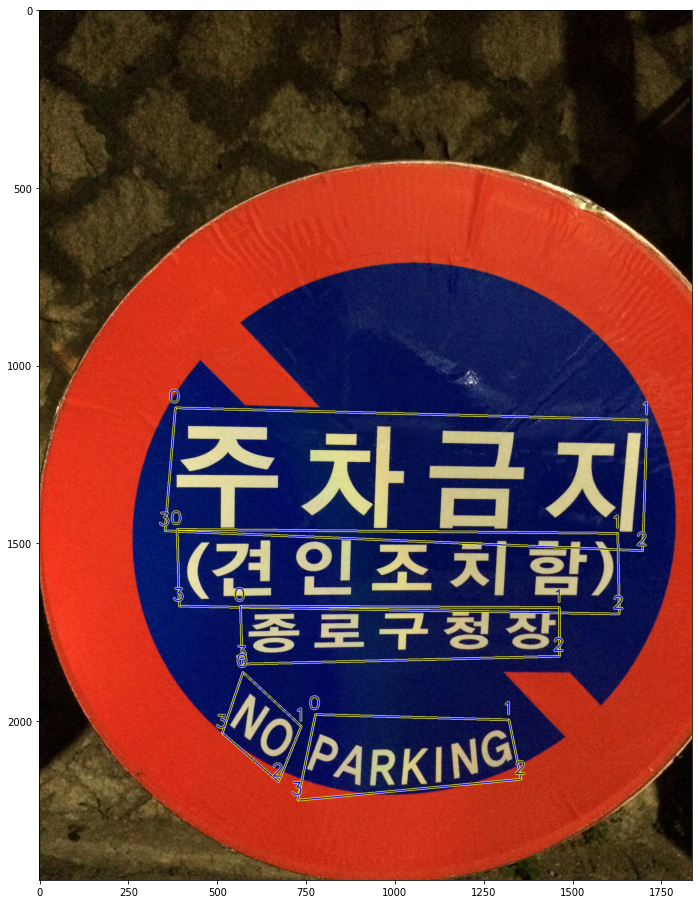

In [22]:
vis = image.copy()
draw_bboxes(vis, bboxes, double_lined=True, thickness=2, thickness_sub=5, write_point_numbers=True)

plt.figure(figsize=(16, 16))
plt.imshow(vis)

# EAST 학습을 위한 데이터 처리

### 글자 영역 하나에 대한 Score map과 Geometry map 생성 과정을 살펴봅시다.

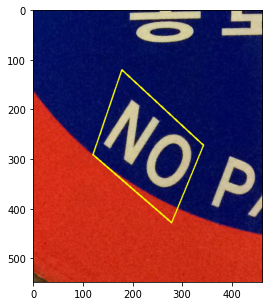

In [12]:
WORD_IDX = 3
VIEW_MARGIN = 120  # pixels
ROI_FIG_SIZE = (5, 5)

target_bbox = np.round(bboxes[WORD_IDX]).astype(np.int32)

x_min, y_min = np.min(target_bbox, axis=0)
x_max, y_max = np.max(target_bbox, axis=0)
src_points = np.array([[x_min - VIEW_MARGIN, y_min - VIEW_MARGIN],
                       [x_max + VIEW_MARGIN, y_min - VIEW_MARGIN],
                       [x_max + VIEW_MARGIN, y_max + VIEW_MARGIN],
                       [x_min - VIEW_MARGIN, y_max + VIEW_MARGIN]], dtype=np.float32)
dst_points = np.array([[0, 0],
                       [x_max - x_min + 2 * VIEW_MARGIN, 0],
                       [x_max - x_min + 2 * VIEW_MARGIN, y_max - y_min + 2 * VIEW_MARGIN],
                       [0, y_max - y_min + 2 * VIEW_MARGIN]], dtype=np.float32)
roi_patch = cv2.warpPerspective(
    image,
    cv2.getPerspectiveTransform(src_points, dst_points),
    dsize=(x_max - x_min + 2 * VIEW_MARGIN, y_max - y_min + 2 * VIEW_MARGIN),
)
target_bbox[:, 0] -= x_min - VIEW_MARGIN
target_bbox[:, 1] -= y_min - VIEW_MARGIN

vis = roi_patch.copy()
draw_bbox(vis, target_bbox, color=(255, 255, 0), thickness=2)

plt.figure(figsize=ROI_FIG_SIZE)
plt.imshow(vis)

### 이미지의 1/4 크기로 Score map과 Geometry map을 초기화합니다.

In [13]:
MAP_SCALE = 0.25
INV_MAP_SCALE = int(1 / MAP_SCALE)

In [14]:
img_h, img_w = roi_patch.shape[:2]
map_h, map_w = int(img_h * MAP_SCALE), int(img_w * MAP_SCALE)

score_map = np.zeros((map_h, map_w, 1), np.float32)
geo_map = np.zeros((map_h, map_w, 5), np.float32)

print('Image:\t\t{}'.format(roi_patch.shape))
print('Score map:\t{}'.format(score_map.shape))
print('Geometry map:\t{}'.format(geo_map.shape))

Image:		(548, 462, 3)
Score map:	(137, 115, 1)
Geometry map:	(137, 115, 5)


### Bounding box shrinking으로 Center region을 구합니다.

In [15]:
def shrink_bbox(bbox, coef=0.3, inplace=False):
    lens = [np.linalg.norm(bbox[i] - bbox[(i + 1) % 4], ord=2) for i in range(4)]
    r = [min(lens[(i - 1) % 4], lens[i]) for i in range(4)]
    
    if not inplace:
        bbox = bbox.copy()
    
    offset = 0 if lens[0] + lens[2] > lens[1] + lens[3] else 1
    for idx in [0, 2, 1, 3]:
        p1_idx, p2_idx = (idx + offset) % 4, (idx + 1 + offset) % 4
        p1p2 = bbox[p2_idx] - bbox[p1_idx]
        dist = np.linalg.norm(p1p2)
        if dist <= 1:
            continue
        bbox[p1_idx] = bbox[p1_idx] + p1p2 / dist * r[p1_idx] * coef
        bbox[p2_idx] = bbox[p2_idx] - p1p2 / dist * r[p2_idx] * coef
    return bbox

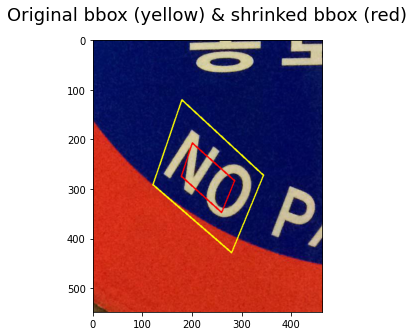

In [16]:
shrinked_bbox = shrink_bbox(target_bbox)

vis = roi_patch.copy()
draw_bbox(vis, target_bbox, color=(255, 255, 0), thickness=2)
draw_bbox(vis, shrinked_bbox, color=(255, 0, 0), thickness=2)

plt.figure(figsize=ROI_FIG_SIZE)
plt.title('Original bbox (yellow) & shrinked bbox (red)', fontsize=18, y=1.05)
plt.imshow(vis)

### Center region에 대해 Score map을 생성합니다.

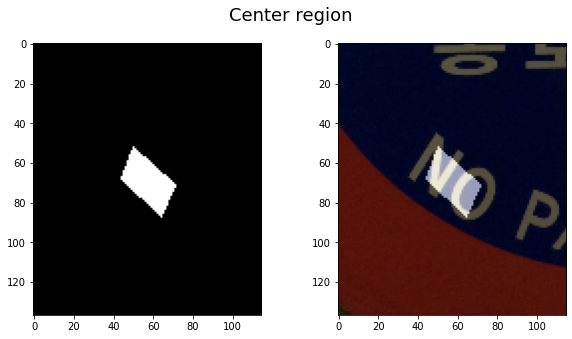

In [17]:
poly = np.round(MAP_SCALE * shrinked_bbox).astype(np.int32)
cv2.fillPoly(score_map, [poly], 1)

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(ROI_FIG_SIZE[0] * 2, ROI_FIG_SIZE[1]))
plt.suptitle('Center region', fontsize=18)
axs[0].imshow(score_map, cmap='gray')
axs[1].imshow(get_superimposed_image(cv2.resize(roi_patch, dsize=(map_w, map_h)), score_map, heatmap=False))

### Bounding box의 각도를 구합니다.

In [18]:
def get_rotate_mat(theta):
    return np.array([[math.cos(theta), -math.sin(theta)],
                     [math.sin(theta), math.cos(theta)]])


def calc_error_from_rect(bbox):
    '''
    Default orientation is x1y1 : left-top, x2y2 : right-top, x3y3 : right-bot, x4y4 : left-bot.
    Calculate the difference between the vertices orientation and default orientation.
    '''
    x_min, y_min = np.min(bbox, axis=0)
    x_max, y_max = np.max(bbox, axis=0)
    rect = np.array([[x_min, y_min], [x_max, y_min], [x_max, y_max], [x_min, y_max]],
                    dtype=np.float32)
    return np.linalg.norm(bbox - rect, axis=0).sum()


def rotate_bbox(bbox, theta, anchor=None):
    points = bbox.T
    if anchor is None:
        anchor = points[:, :1]
    rotated_points = np.dot(get_rotate_mat(theta), points - anchor) + anchor
    return rotated_points.T


def find_min_rect_angle(bbox, rank_num=10):
    '''
    Find the best angle to rotate poly and obtain min rectangle.
    '''
    areas = []
    angles = np.arange(-90, 90) / 180 * math.pi
    for theta in angles:
        rotated_bbox = rotate_bbox(bbox, theta)
        x_min, y_min = np.min(rotated_bbox, axis=0)
        x_max, y_max = np.max(rotated_bbox, axis=0)
        areas.append((x_max - x_min) * (y_max - y_min))

    best_angle, min_error = -1, float('inf')
    for idx in np.argsort(areas)[:rank_num]:
        rotated_bbox = rotate_bbox(bbox, angles[idx])
        error = calc_error_from_rect(rotated_bbox)
        if error < min_error:
            best_angle, min_error = angles[idx], error

    return best_angle

(-1.0, 1.0)

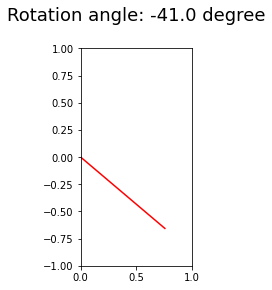

In [19]:
theta = find_min_rect_angle(target_bbox)

plt.figure(figsize=(2, 4))
plt.plot([0, math.cos(theta)], [0, math.sin(theta)], 'r-')
plt.title('Rotation angle: {} degree'.format(theta * 180 / math.pi), fontsize=18, y=1.1)
plt.xlim([0, 1])
plt.ylim([-1, 1])

### Bounding box의 각도만큼 회전된 축 상에서 두 축을 따라 값이 선형적으로 증가하는 Map을 각각 생성합니다.

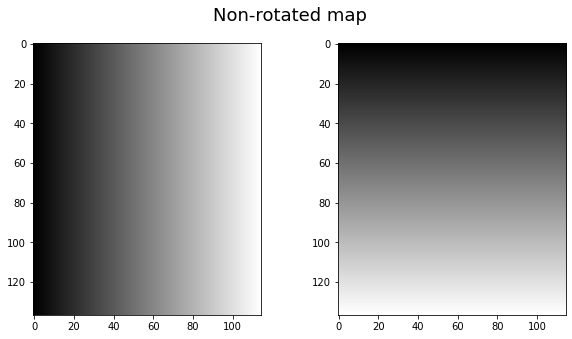

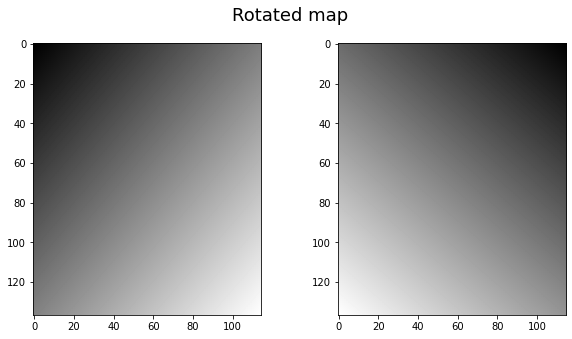

In [20]:
def get_rotated_coords(h, w, theta, anchor):
    anchor = anchor.reshape(2, 1)
    rotate_mat = get_rotate_mat(theta)
    x, y = np.meshgrid(np.arange(w), np.arange(h))
    x_lin = x.reshape((1, x.size))
    y_lin = y.reshape((1, x.size))
    coord_mat = np.concatenate((x_lin, y_lin), 0)
    rotated_coord = np.dot(rotate_mat, coord_mat - anchor) + anchor
    rotated_x = rotated_coord[0, :].reshape(x.shape)
    rotated_y = rotated_coord[1, :].reshape(y.shape)
    return rotated_x, rotated_y


rotated_x, rotated_y = get_rotated_coords(map_h, map_w, 0, target_bbox[0] * MAP_SCALE)

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(ROI_FIG_SIZE[0] * 2, ROI_FIG_SIZE[1]))
plt.suptitle('Non-rotated map', fontsize=18)
axs[0].imshow(rotated_x, cmap='gray')
axs[1].imshow(rotated_y, cmap='gray')


rotated_x, rotated_y = get_rotated_coords(map_h, map_w, theta, target_bbox[0] * MAP_SCALE)

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(ROI_FIG_SIZE[0] * 2, ROI_FIG_SIZE[1]))
plt.suptitle('Rotated map', fontsize=18)
axs[0].imshow(rotated_x, cmap='gray')
axs[1].imshow(rotated_y, cmap='gray')

### RBOX 형식의 GT bbox를 계산합니다.

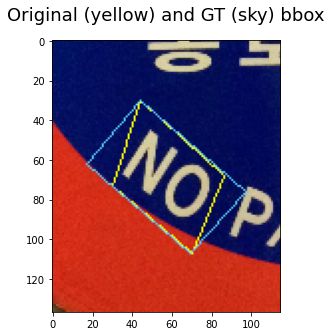

In [21]:
center_mask = np.zeros((map_h, map_w), np.float32)
poly = np.round(MAP_SCALE * shrinked_bbox).astype(np.int32)
cv2.fillPoly(center_mask, [poly], 1)

rotated_bbox = rotate_bbox(target_bbox, theta)
rotated_bbox *= MAP_SCALE

x_min, y_min = np.min(rotated_bbox, axis=0)
x_max, y_max = np.max(rotated_bbox, axis=0)

gt_rbox = np.array([[x_min, y_min], [x_max, y_min], [x_max, y_max], [x_min, y_max]],
                   dtype=np.float32)
gt_rbox = rotate_bbox(gt_rbox, -theta)

plt.figure(figsize=ROI_FIG_SIZE)
plt.title('Original (yellow) and GT (sky) bbox', fontsize=18, y=1.05)
vis = cv2.resize(roi_patch, dsize=(map_w, map_h))
draw_bbox(vis, target_bbox * MAP_SCALE, color=(255, 255, 0))
draw_bbox(vis, gt_rbox, color=(85, 206, 255))
plt.imshow(vis, cmap='gray')

### Geometry map을 구성하는 d1, d2, d3, d4, θ를 생성합니다.

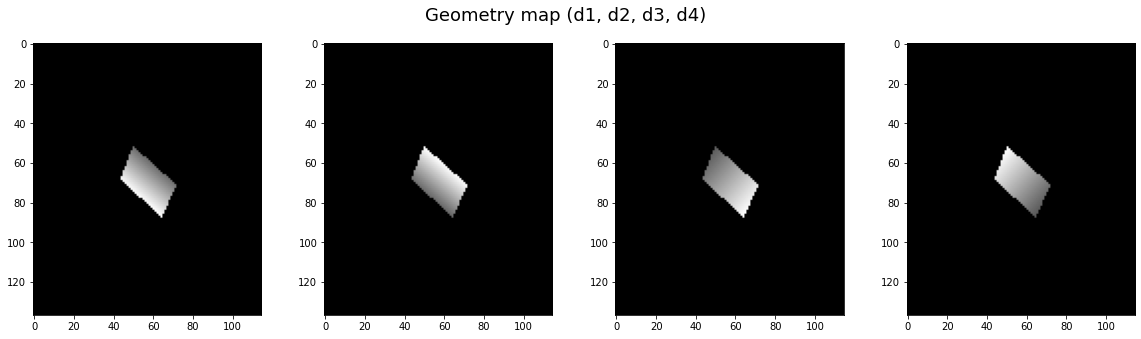

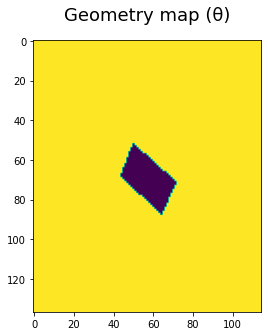

In [22]:
d1, d2 = rotated_y - y_min, y_max - rotated_y
d1[d1 < 0] = 0
d2[d2 < 0] = 0
d3, d4 = rotated_x - x_min, x_max - rotated_x
d3[d3 < 0] = 0
d4[d4 < 0] = 0

geo_map[:, :, 0] += d1 * center_mask * INV_MAP_SCALE
geo_map[:, :, 1] += d2 * center_mask * INV_MAP_SCALE
geo_map[:, :, 2] += d3 * center_mask * INV_MAP_SCALE
geo_map[:, :, 3] += d4 * center_mask * INV_MAP_SCALE
geo_map[:, :, 4] += theta * center_mask

fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(ROI_FIG_SIZE[0] * 4, ROI_FIG_SIZE[1]))
plt.suptitle('Geometry map (d1, d2, d3, d4)', fontsize=18)
for idx in range(4):
    axs[idx].imshow(geo_map[:, :, idx], cmap='gray')

plt.figure(figsize=ROI_FIG_SIZE)
plt.title('Geometry map (θ)', fontsize=18, y=1.05)
plt.imshow(geo_map[:, :, 4])

### 직관적인 시각화를 위해 d1, d2, d3, d4를 정규화합니다. (학습에는 정규화 하지 않은 버전을 이용)

In [23]:
def normalize_geo_map(geo_map):
    """
    Use this method for visualization purposes only.
    """
    geo_map = geo_map.copy()
    for channel in range(4):
        num_blobs, idx_map = cv2.connectedComponents(np.array(geo_map[:, :, channel] > 0, dtype=np.uint8))
        for blob_idx in range(1, num_blobs):
            blob_region = idx_map == blob_idx
            geo_map[:, :, channel][blob_region] /= geo_map[:, :, channel][blob_region].max()
    return (geo_map * 255).astype(np.uint8)

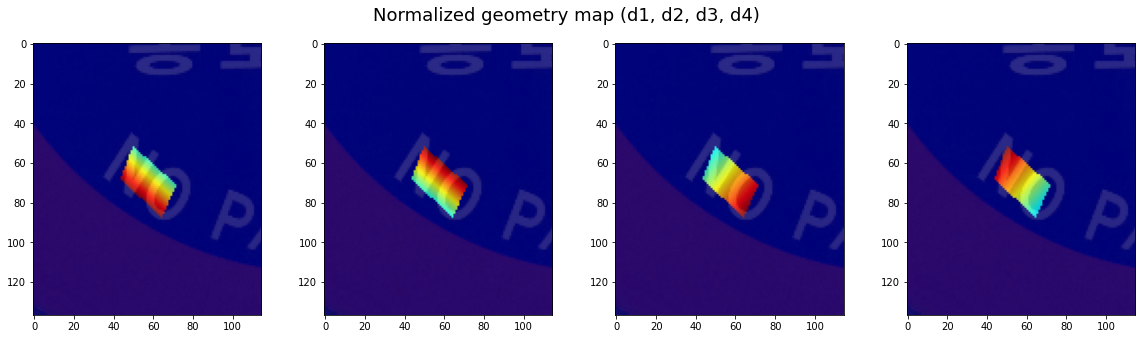

In [24]:
img = cv2.resize(roi_patch, dsize=(score_map.shape[1], score_map.shape[0]))
vis_geo_map = normalize_geo_map(geo_map)

fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(ROI_FIG_SIZE[0] * 4, ROI_FIG_SIZE[1]))
plt.suptitle('Normalized geometry map (d1, d2, d3, d4)', fontsize=18)
for idx in range(4):
    axs[idx].imshow(get_superimposed_image(img, vis_geo_map[:, :, idx], w_map=0.8))

### GT bbox 영역 내의 Geometry map을 시각화해봅니다.

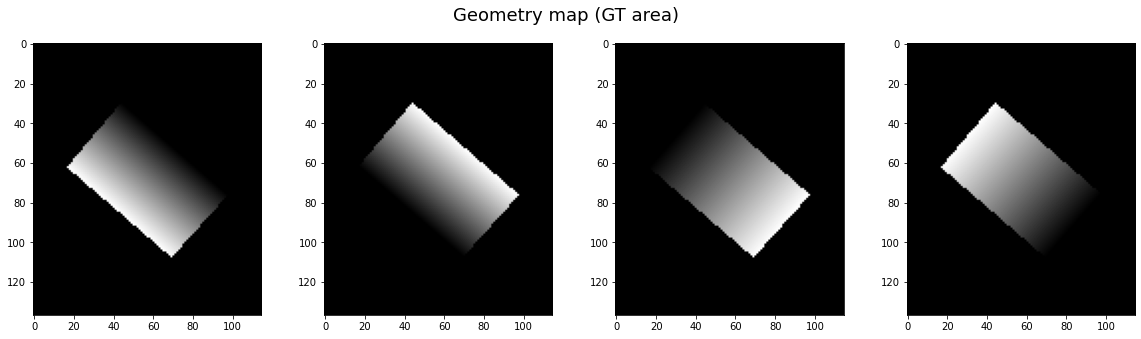

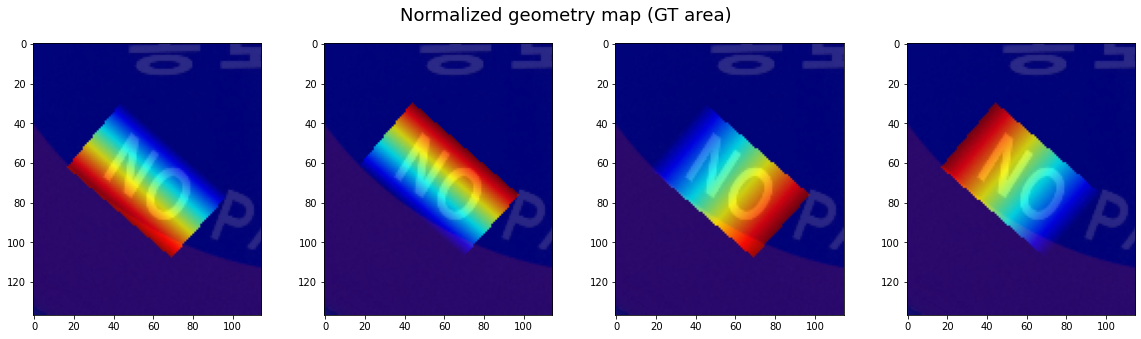

In [25]:
geo_map_rbox = np.zeros((map_h, map_w, 5), np.float32)

x_min, y_min = np.min(rotated_bbox, axis=0)
x_max, y_max = np.max(rotated_bbox, axis=0)

gt_rbox = np.array([[x_min, y_min], [x_max, y_min], [x_max, y_max], [x_min, y_max]],
                   dtype=np.float32)
gt_rbox = rotate_bbox(gt_rbox, -theta)
gt_rbox_mask = np.zeros((map_h, map_w), np.float32)
cv2.fillPoly(gt_rbox_mask, [np.round(gt_rbox).astype(np.int32)], 1)

geo_map_rbox[:, :, 0] += d1 * gt_rbox_mask * INV_MAP_SCALE
geo_map_rbox[:, :, 1] += d2 * gt_rbox_mask * INV_MAP_SCALE
geo_map_rbox[:, :, 2] += d3 * gt_rbox_mask * INV_MAP_SCALE
geo_map_rbox[:, :, 3] += d4 * gt_rbox_mask * INV_MAP_SCALE

fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(ROI_FIG_SIZE[0] * 4, ROI_FIG_SIZE[1]))
plt.suptitle('Geometry map (GT area)', fontsize=18)
for idx in range(4):
    axs[idx].imshow(geo_map_rbox[:, :, idx], cmap='gray')
    
img = cv2.resize(roi_patch, dsize=(score_map.shape[1], score_map.shape[0]))
vis_geo_map_rbox = normalize_geo_map(geo_map_rbox)

fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(ROI_FIG_SIZE[0] * 4, ROI_FIG_SIZE[1]))
plt.suptitle('Normalized geometry map (GT area)', fontsize=18)
for idx in range(4):
    axs[idx].imshow(get_superimposed_image(img, vis_geo_map_rbox[:, :, idx], w_map=0.8))

### 모든 글자 영역에 대해 각각 이 과정을 수행하면 한 샘플에 대한 GT를 얻을 수 있습니다.

Image:		(2448, 1836, 3)
Score map:	(612, 459, 1)
Geometry map:	(612, 459, 5)


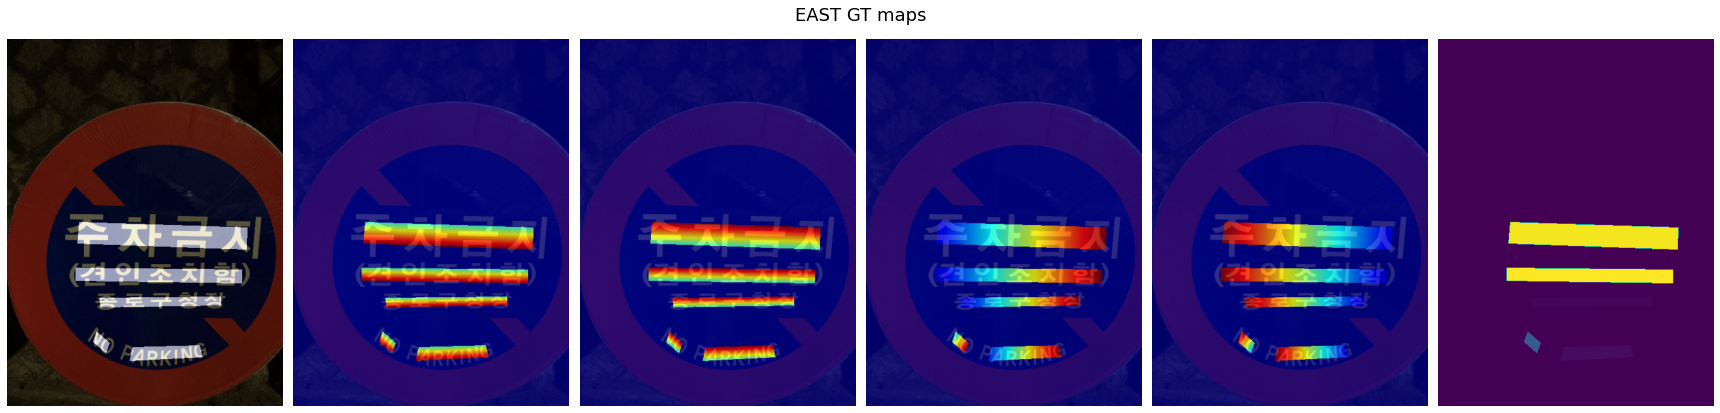

In [26]:
MAP_SCALE = 0.25
INV_MAP_SCALE = int(1 / MAP_SCALE)

img_h, img_w = image.shape[:2]
map_h, map_w = int(img_h * MAP_SCALE), int(img_w * MAP_SCALE)

score_map = np.zeros((map_h, map_w, 1), np.float32)
geo_map = np.zeros((map_h, map_w, 5), np.float32)

print('Image:\t\t{}'.format(image.shape))
print('Score map:\t{}'.format(score_map.shape))
print('Geometry map:\t{}'.format(geo_map.shape))

word_polys = []

for bbox in bboxes:
    poly = np.around(MAP_SCALE * shrink_bbox(bbox)).astype(np.int32)
    word_polys.append(poly)
    
    center_mask = np.zeros((map_h, map_w), np.float32)
    cv2.fillPoly(center_mask, [poly], 1)

    theta = find_min_rect_angle(bbox)
    rotated_bbox = rotate_bbox(bbox, theta)
    rotated_bbox *= MAP_SCALE
    x_min, y_min = np.min(rotated_bbox, axis=0)
    x_max, y_max = np.max(rotated_bbox, axis=0)

    rotated_x, rotated_y = get_rotated_coords(map_h, map_w, theta, bbox[0] * MAP_SCALE)

    d1, d2 = rotated_y - y_min, y_max - rotated_y
    d1[d1 < 0] = 0
    d2[d2 < 0] = 0
    d3, d4 = rotated_x - x_min, x_max - rotated_x
    d3[d3 < 0] = 0
    d4[d4 < 0] = 0
    geo_map[:, :, 0] += d1 * center_mask * INV_MAP_SCALE
    geo_map[:, :, 1] += d2 * center_mask * INV_MAP_SCALE
    geo_map[:, :, 2] += d3 * center_mask * INV_MAP_SCALE
    geo_map[:, :, 3] += d4 * center_mask * INV_MAP_SCALE
    geo_map[:, :, 4] += theta * center_mask

cv2.fillPoly(score_map, word_polys, 1)


img = cv2.resize(image, dsize=(score_map.shape[1], score_map.shape[0]))
vis_geo_map = normalize_geo_map(geo_map)


# Plot figures

fig, axs = plt.subplots(ncols=6, nrows=1, figsize=(24, 10))
plt.suptitle('EAST GT maps', fontsize=18, y=0.78)
axs = axs.flatten()
for x in axs:
    x.axis('off')
fig.tight_layout()
axs[0].imshow(get_superimposed_image(img, score_map, heatmap=False))
for idx in range(4):
    axs[idx + 1].imshow(get_superimposed_image(img, vis_geo_map[:, :, idx], w_map=0.8))
axs[5].imshow(vis_geo_map[:, :, 4])

# Inference

In [27]:
model = EAST(pretrained=False)
# model = model.cuda()
_ = model.eval()

In [28]:
model.load_state_dict(torch.load('./trained_models_All/model_epoch_200.pth', map_location='cpu'))

<All keys matched successfully>

### 대상 이미지를 불러옵니다.

Original image:	(774, 609, 3)


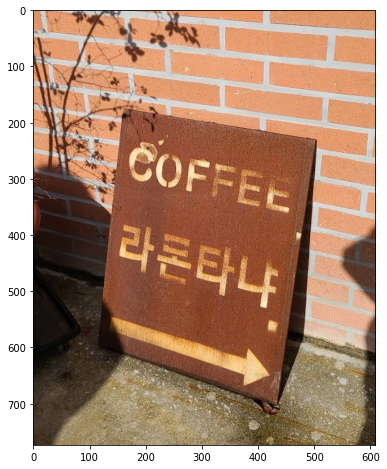

In [29]:
SAMPLE_IDX = 0
FIG_SIZE = (8, 8)

image = imread('test_images/image_02.png')
orig_size = image.shape[:2]

# image_fnames = sorted(ufo_anno['images'].keys())
# image_fname = image_fnames[SAMPLE_IDX]
# image_fpath = osp.join(DATASET_DIR, 'images', image_fname)
# image = imread(image_fpath)

print('Original image:\t{}'.format(image.shape))

plt.figure(figsize=FIG_SIZE)
plt.imshow(image)

### Batch 구성을 위해 일정 크기로 조정합니다.

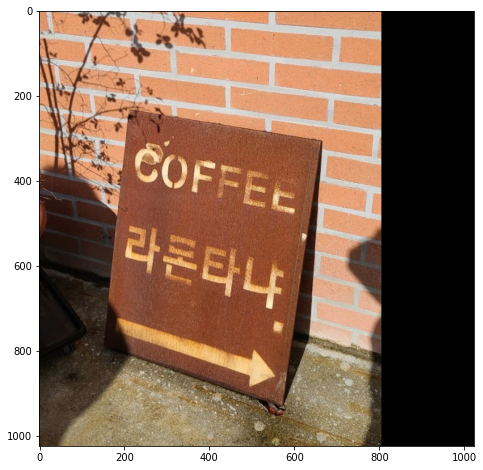

In [30]:
INPUT_SIZE = 1024

prep_fn = A.Compose([
    A.LongestMaxSize(INPUT_SIZE),
    A.PadIfNeeded(min_height=INPUT_SIZE, min_width=INPUT_SIZE, position=A.PadIfNeeded.PositionType.TOP_LEFT, border_mode=cv2.BORDER_CONSTANT),
    A.Normalize(), ToTensorV2()
])

# 시각화를 위해 Normalize와 Tensorize를 제외한 버전
prep_fn_vis = A.Compose([
    A.LongestMaxSize(INPUT_SIZE),
    A.PadIfNeeded(min_height=INPUT_SIZE, min_width=INPUT_SIZE, position=A.PadIfNeeded.PositionType.TOP_LEFT, border_mode=cv2.BORDER_CONSTANT)
])

vis = prep_fn_vis(image=image)['image']
plt.figure(figsize=FIG_SIZE)
plt.imshow(vis)

### 먼저 검출 결과를 확인해봅니다.

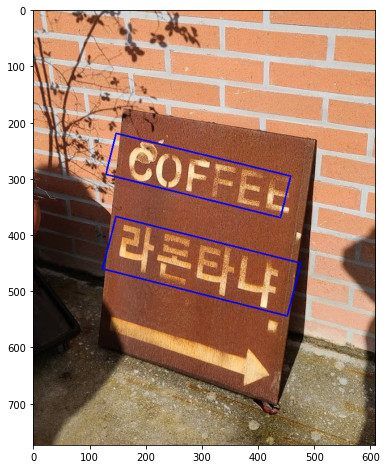

In [31]:
bboxes = detect(model, [image], INPUT_SIZE)[0]

vis = image.copy()
draw_bboxes(vis, bboxes, thickness=2)

plt.figure(figsize=FIG_SIZE)
plt.imshow(vis)

### 네트워크의 Output을 시각화해봅니다.

Original image:	(774, 609, 3)
Input image:	torch.Size([3, 1024, 1024])
Score map:	(256, 202)
Geometry map:	(256, 202, 5)


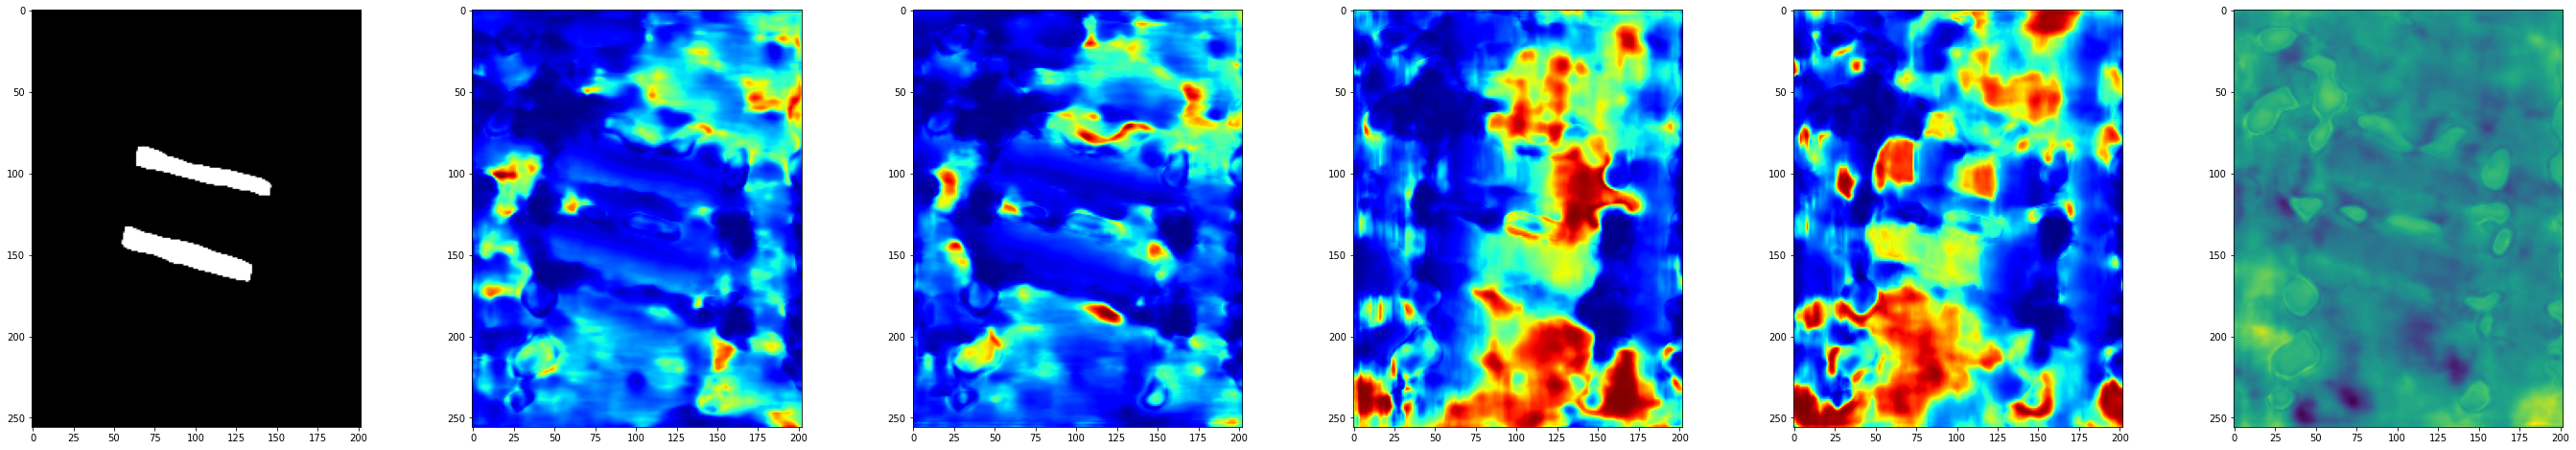

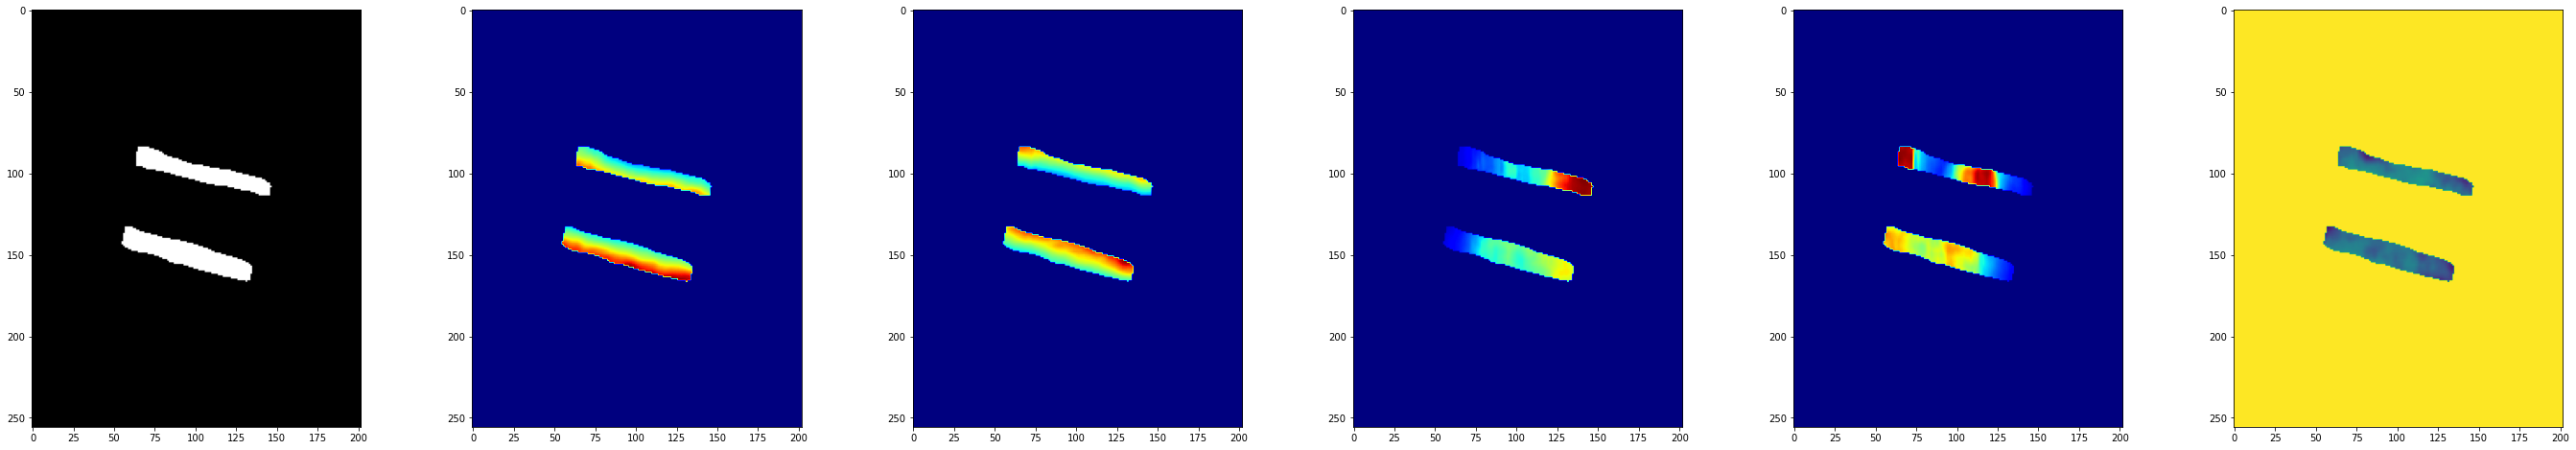

In [32]:
SCORE_THRES = 0.9

device = list(model.parameters())[0].device
batch = torch.stack([prep_fn(image=image)['image']], dim=0).to(device)

with torch.no_grad():
    score_maps, geo_maps = model(batch)
score_maps, geo_maps = score_maps.cpu().numpy(), geo_maps.cpu().numpy()
score_map, geo_map = score_maps[0], geo_maps[0]
score_map, geo_map = score_map.transpose(1, 2, 0), geo_map.transpose(1, 2, 0)
score_map = score_map.squeeze()

map_margin = int(abs(orig_size[0] - orig_size[1]) * MAP_SCALE * INPUT_SIZE / max(orig_size))
if orig_size[0] > orig_size[1]:
    score_map, geo_map = score_map[:, :-map_margin], geo_map[:, :-map_margin, :]
else:
    score_map, geo_map = score_map[:-map_margin, :], geo_map[:-map_margin, :, :]

fig, axs = plt.subplots(ncols=6, nrows=1, figsize=(FIG_SIZE[0] * 6, FIG_SIZE[1]))
axs[0].imshow(score_map, cmap='gray')
for idx in range(4):
    axs[idx + 1].imshow(geo_map[:, :, idx], cmap='jet')
axs[5].imshow(geo_map[:, :, 4])


center_mask = score_map > SCORE_THRES
fig, axs = plt.subplots(ncols=6, nrows=1, figsize=(FIG_SIZE[0] * 6, FIG_SIZE[1]))
axs[0].imshow(center_mask, cmap='gray')
for idx in range(4):
    axs[idx + 1].imshow(geo_map[:, :, idx] * center_mask, cmap='jet')
axs[5].imshow(geo_map[:, :, 4] * center_mask)

print('Original image:\t{}'.format(image.shape))
print('Input image:\t{}'.format(batch[0].shape))
print('Score map:\t{}'.format(score_map.shape))
print('Geometry map:\t{}'.format(geo_map.shape))

### 예측한 Score map과 Geometry map으로부터 Bounding box를 구합니다.

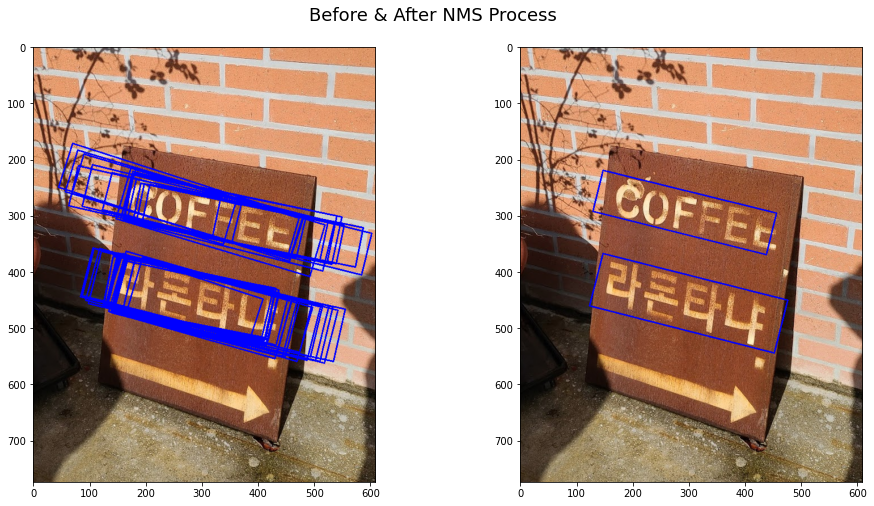

In [33]:
NMS_THRES = 0.2


xy_text = np.argwhere(score_map > SCORE_THRES)[:, ::-1].copy()  # (n x 2)

if xy_text.size == 0:
    bboxes = np.zeros((0, 4, 2), dtype=np.float32)
else:
    xy_text = xy_text[np.argsort(xy_text[:, 1])]  # Row-wise로 정렬
    valid_pos = xy_text * INV_MAP_SCALE
    valid_geo = geo_map[xy_text[:, 1], xy_text[:, 0], :]  # (n x 5)
    
    indices, bboxes = [], []
    for idx, ((x, y), g) in enumerate(zip(valid_pos, valid_geo)):
        y_min, y_max = y - g[0], y + g[1]
        x_min, x_max = x - g[2], x + g[3]
        rotate_mat = get_rotate_mat(-g[4])
        
        bbox = np.array([[x_min, y_min], [x_max, y_min], [x_max, y_max], [x_min, y_max]], dtype=np.float32)
        anchor = np.array([x, y], dtype=np.float32).reshape(2, 1)
        rotated_bbox = (np.dot(rotate_mat, bbox.T - anchor) + anchor).T

        # 이미지 범위에서 벗어나는 bbox는 탈락
        if bbox[:, 0].min() < 0 or bbox[:, 0].max() >= score_map.shape[1] * INV_MAP_SCALE:
            continue
        elif bbox[:, 1].min() < 0 or bbox[:, 1].max() >= score_map.shape[0] * INV_MAP_SCALE:
            continue

        indices.append(idx)
        bboxes.append(rotated_bbox.flatten())
    bboxes = np.array(bboxes)
    
    raw_bboxes = bboxes.reshape(-1, 4, 2)
    
    # 좌표 정보에 Score map에서 가져온 Score를 추가
    scored_bboxes = np.zeros((bboxes.shape[0], 9), dtype=np.float32)
    scored_bboxes[:, :8] = bboxes
    scored_bboxes[:, 8] = score_map[xy_text[indices, 1], xy_text[indices, 0]]
    
    # LA-NMS 적용
    nms_bboxes = lanms.merge_quadrangle_n9(scored_bboxes.astype('float32'), NMS_THRES)
    nms_bboxes = nms_bboxes[:, :8].reshape(-1, 4, 2)
    
    # 원본 이미지 크기에 맞게 bbox 크기 보정
    raw_bboxes *= max(orig_size) / INPUT_SIZE
    nms_bboxes *= max(orig_size) / INPUT_SIZE

fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(FIG_SIZE[0] * 2, FIG_SIZE[1]))
plt.suptitle('Before & After NMS Process', fontsize=18, y=0.95)

vis = image.copy()
draw_bboxes(vis, raw_bboxes[::50], thickness=2)
axs[0].imshow(vis)

vis = image.copy()
draw_bboxes(vis, nms_bboxes, thickness=2)
axs[1].imshow(vis)